<a href="https://colab.research.google.com/github/RitwickRoy/my_public_workspace/blob/master/HouseholdPowerConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**<font size="3">Project Overview</font>**
1. [Importing TXT file](#Importing_txt_file)<br>
    1.1. [Summary Statistics](#Summary_Statistics)<br>
2. [Data Preparation](#Data_Preparation)<br>
    2.1. [Convert format](#Convert_format)<br>
    2.2. [Missing Data](#Missing_data)<br>
3. [Exploratory Data Analysis](#Exploratory_Data_Analysis)<br>
    3.1. [Feature Trend via resampling](#Feature_trend_via_resampling)<br>
    3.2. [Aggregated data trend](#Aggregated_data_trend)<br>
    3.3. [Feature Relationships](#Feature_relationships)<br>
    3.4. [EDA Summary](#EDA_Summary)<br> 
4. [Time Series Analysis](#TSA)<br>
    4.1 [Forecasting Global active power for the next-day](#GAP_ND)<br>
    4.1.1 [Data preparation for next day forecasting](#DP_ND)<br>
    4.1.2 [Baseline naive forecasting next day](#BN_ND)<br>
    4.1.3 [Building Models for next day forecasting](#BM_ND)<br>
    4.1.3a [Observations on model using sampling rate 60](#BM_60SR_ND_obs)<br>
    4.2.1 [Data preparation using hourly resampled aggregate data for next day forecasting](#DP_HR_ND)<br>
    4.2.2 [Building Models using hourly resampled aggregate data for next day forecasting](#BM_HR_ND)<br>
    4.2.2a [Observations on model using hourly resampled aggregate data for nex-day forecasting](#BM_HR_ND_obs)<br>
    4.3 [Forecasting Global active power for next-week](#GAP_NW)<br>
    4.3.1 [Preparing data using daily resampled aggregate data for next week Forecasting](#Data_preparation_DR_NW)<br>
    4.3.2 [Baseline naive forecasting for next week using daily resampled aggreatge data](#BLNF_DR_NW)<br>
    4.3.2 [Building Models using daily resampled aggregate data for next-week forecasting.](#BM_DR_NW)<br>
    4.3.2a [Observation on Models using daily resampled aggreagate data for next-week forecasting](#BM_DR_NW_obs)<br>
    4.4.1 [Preparing data using hourly resampled aggregate data for next week Forecasting](#DP_HR_NW)<br>
    4.4.2 [Baseline naive forecasting for next week using hourly resampled aggreatge data](#BLNF_HR_NW)<br>
    4.4.3 [Building Models using hourly resampled aggregate data for next-week forecasting.](#BM_HR_NW)<br>
    4.4.3a [Observation on Models using daily resampled aggreagate data for next-week forecasting](#BM_HR_NW_obs)<br>
    4.5 [Forecasting Global active power for next-hour](#GAP_NH)<br>
    4.5.1 [Preparing data using 10min resampled aggregate data for next hour Forecasting](#Data_preparation_HR_NH)<br>
    4.5.2 [Baseline naive forecasting for next hour using 10min resampled aggreatge data](#BLNF_HR_NH)<br>
    4.5.3 [Building Models using 10min resampled aggregate data for next-hour forecasting.](#BM_HR_NH)<br>
    4.5.3a [Observation on Models using 10min resampled aggreagate data for next-hour forecasting](#BM_HR_NH_obs)<br>



5. [Conclusion](#Conclusion)<br>
6. [Appendix](#Appendix)<br>
(#Drop_Current_Combine_Sub_metering)<br>
    6.1. [XGBoost](#XGBoost)<br>
    6.2. [ARIMA](#ARIMA)<br>


***Imports***


In [ ]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.layers import SimpleRNN
from keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from xgboost import XGBRegressor

#Dataset and description
* **This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).**
***https://www.kaggle.com/uciml/electric-power-consumption-data-set***


#Attribute Information:
* **date:**  Date in format dd/mm/yyyy \
* **time:**  time in format hh:mm:ss \
* **global_active_power:**  household global minute-averaged active power (in kilowatt) \
* **global_reactive_power:**  household global minute-averaged reactive power (in kilowatt) \
* **voltage:**  minute-averaged voltage (in volt) \
* **global_intensity:**  household global minute-averaged current intensity (in ampere) \
* **sub_metering_1:**  energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). \
* **sub_metering_2:**  energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. \
* **sub_metering_3:**  energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. 

#Task:  
***Given the history of attributes for 6 days, predict the Global active power for the 7th day.***

<a id='Importing_TXT_file'></a>
## 1. Importing TXT file

In [ ]:
hhpc_df = pd.read_table("household_power_consumption.txt",sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<a id='Summary_Statistics'></a>
### 1.1. Summary Statistics

In [ ]:
hhpc_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
hhpc_df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [ ]:
hhpc_df.shape

(2075259, 8)

<a id='Data_Preparation'></a>
## 2. Data Preparation
<a id='Convert_format'></a>
### 2.1. Convert format

* *Convert Date and Time from object to datetime format*
* *Convert power, voltage, intensity and metering from object to float32*

In [ ]:
hhpc_df['DateTime'] = pd.to_datetime(hhpc_df['Date']+' '+hhpc_df['Time'])
hhpc_df['Global_active_power']=pd.to_numeric(hhpc_df['Global_active_power'],errors='coerce')
hhpc_df['Global_reactive_power']=pd.to_numeric(hhpc_df['Global_reactive_power'],errors='coerce')
hhpc_df['Voltage']=pd.to_numeric(hhpc_df['Voltage'],errors='coerce')
hhpc_df['Global_intensity']=pd.to_numeric(hhpc_df['Global_intensity'],errors='coerce')
hhpc_df['Sub_metering_1']=pd.to_numeric(hhpc_df['Sub_metering_1'],errors='coerce')
hhpc_df['Sub_metering_2']=pd.to_numeric(hhpc_df['Sub_metering_2'],errors='coerce')

In [ ]:
hhpc_df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [ ]:
hhpc_df.drop(columns=['Date','Time'],inplace=True)

* *Look for missing data*

In [ ]:
hhpc_df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
DateTime                     0
dtype: int64

* *to avoid gaps in the timeseries data replace missing values with mean values*

In [ ]:
hhpc_df.fillna(hhpc_df.mean(),inplace=True)
hhpc_df.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
DateTime                 0
dtype: int64

* *check summary stats again*

In [ ]:
hhpc_df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


<a id='Exploratory_Data_Analysis'></a>
## 3. Exploratory Data Analysis
<a id='Feature_Trend_via_resampling'></a>
### 3.1. Feature trend via resampling

* *plot unsampled data first*

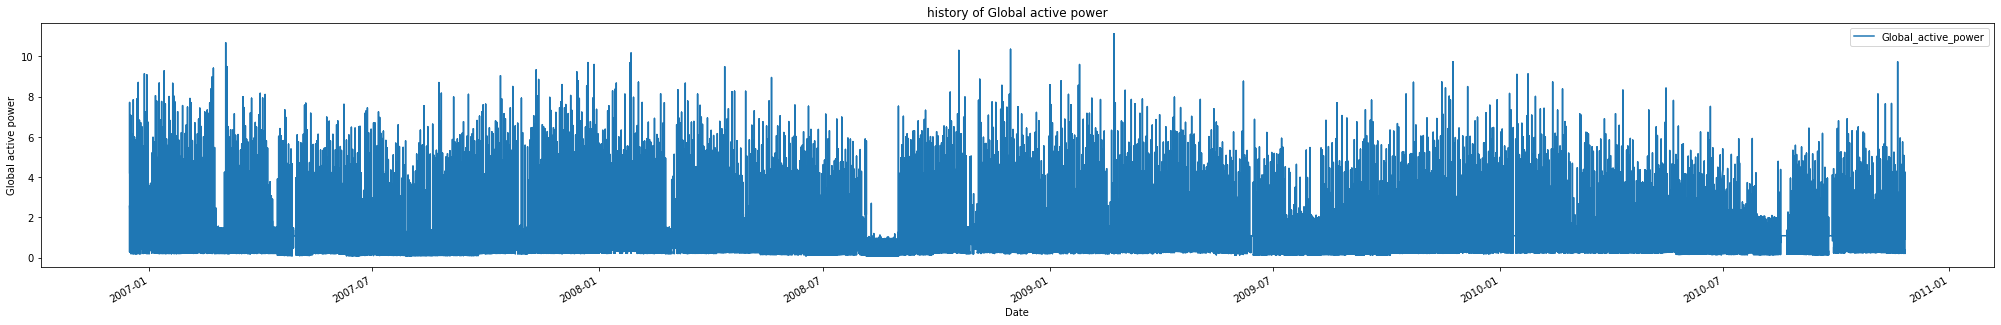

In [ ]:
fig = hhpc_df.plot(x='Date',y='Global_active_power', kind='line', figsize=(35,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global active power')
fig.set(title='history of Global active power')
plt.show(fig)

* *Resample the data to see patterns*

In [ ]:
hhpc_rsmpl = hhpc_df.copy()

In [ ]:
hhpc_rsmpl.index = hhpc_df.DateTime

In [ ]:
Weekly = hhpc_rsmpl.resample('W').sum()
Hourly = hhpc_rsmpl.resample('H').sum()
Daily = hhpc_rsmpl.resample('D').sum()
Min10 = hhpc_rsmpl.resample('10min').sum()

In [ ]:
Weekly_avg = hhpc_rsmpl.resample('W').mean()
Hourly_avg = hhpc_rsmpl.resample('H').mean()
Daily_avg = hhpc_rsmpl.resample('D').mean()
Min10_avg = hhpc_rsmpl.resample('10min').mean()

In [ ]:
Weekly['Voltage_avg'] = Weekly_avg['Voltage']
Hourly['Voltage_avg'] = Hourly_avg['Voltage']
Daily['Voltage_avg'] = Daily_avg['Voltage']
Min10['Voltage_avg'] = Min10_avg['Voltage']

In [ ]:
Weekly_plt = Weekly.copy()
Hourly_plt = Hourly.copy()
Daily_plt = Daily.copy()
Min10_plt = Min10.copy()

In [ ]:
Weekly_plt['Date_s'] = Weekly.index
Hourly_plt['Date_s'] = Hourly.index
Daily_plt['Date_s'] = Daily.index
Min10_plt['Date_s'] = Min10.index

* *Weekly pattern*

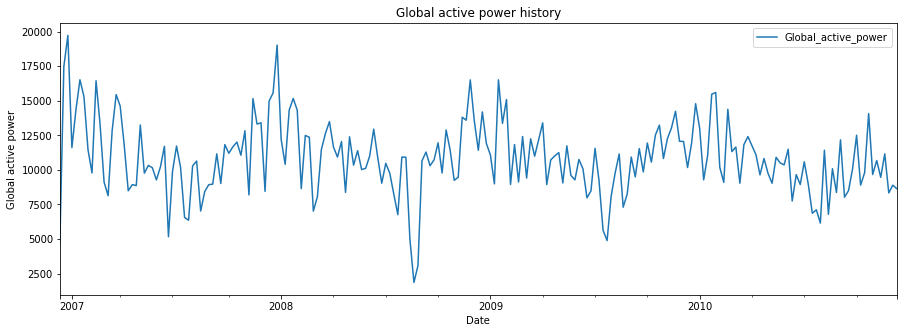

In [ ]:
fig = Weekly_plt.plot(x='Date_s',y='Global_active_power', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global active power')
fig.set(title='Global active power history')
plt.show(fig)

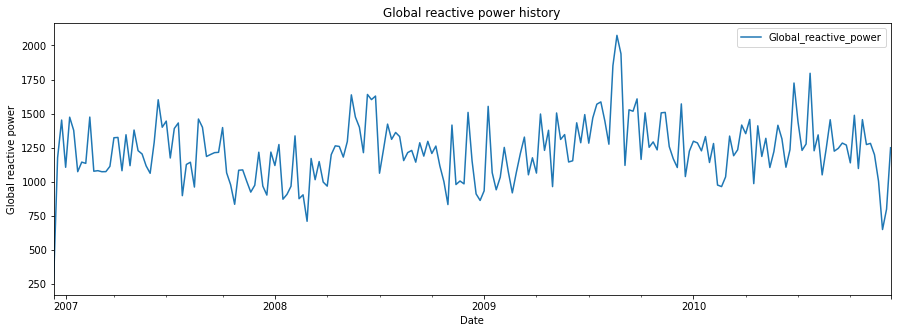

In [ ]:
fig = Weekly_plt.plot(x='Date_s',y='Global_reactive_power', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global reactive power')
fig.set(title='Global reactive power history')
plt.show(fig)

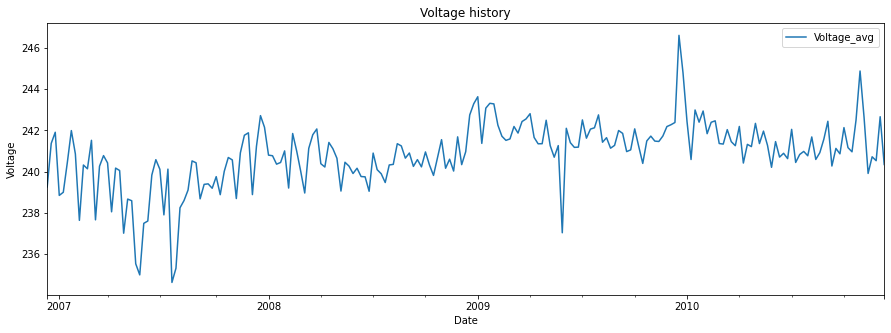

In [ ]:
fig = Weekly_plt.plot(x='Date_s',y='Voltage_avg', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Voltage')
fig.set(title='Voltage history')
plt.show(fig)

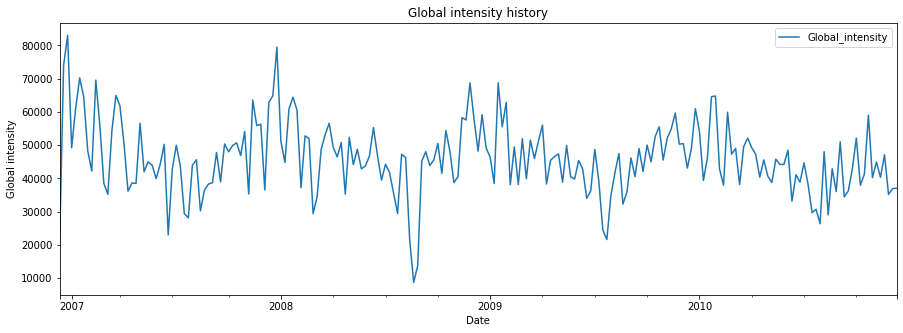

In [ ]:
fig = Weekly_plt.plot(x='Date_s',y='Global_intensity', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global intensity')
fig.set(title='Global intensity history')
plt.show(fig)

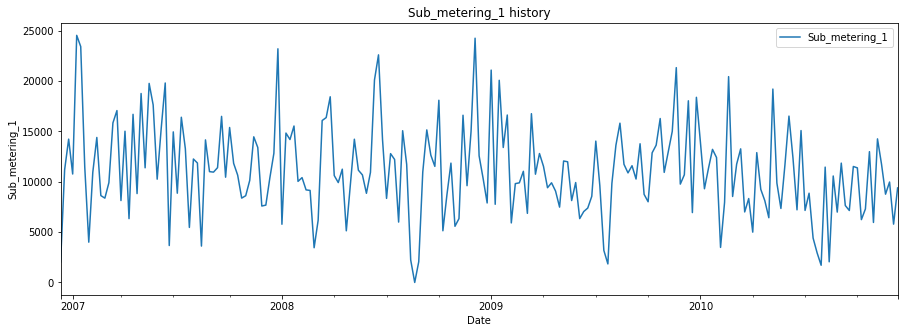

In [ ]:
fig = Weekly_plt.plot(x='Date_s',y='Sub_metering_1', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Sub_metering_1')
fig.set(title='Sub_metering_1 history')
plt.show(fig)

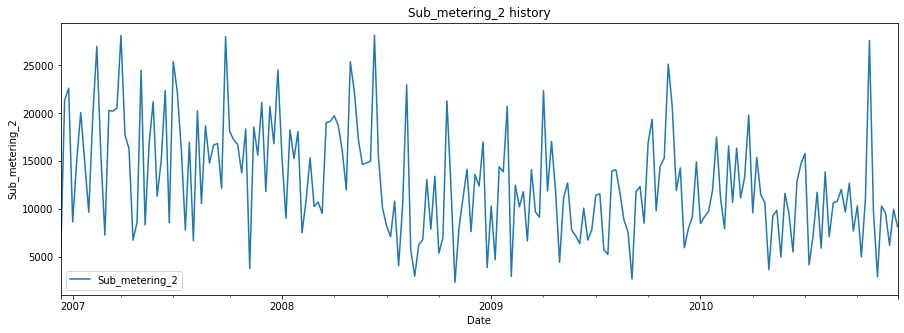

In [ ]:
fig = Weekly_plt.plot(x='Date_s',y='Sub_metering_2', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Sub_metering_2')
fig.set(title='Sub_metering_2 history')
plt.show(fig)

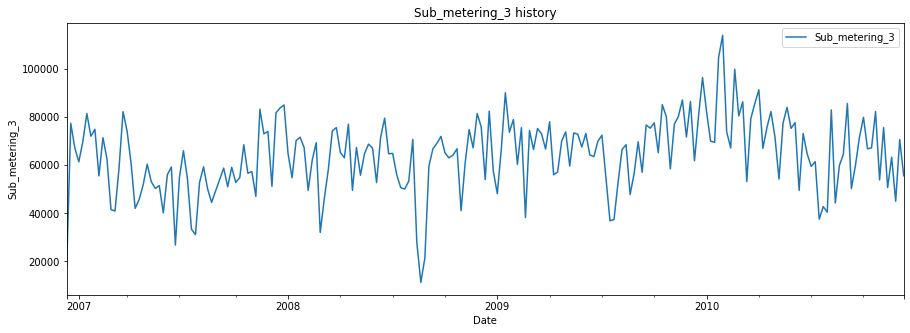

In [ ]:
fig = Weekly_plt.plot(x='Date_s',y='Sub_metering_3', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Sub_metering_3')
fig.set(title='Sub_metering_3 history')
plt.show(fig)

* *Hourly patterns*

In [ ]:
Hourly_1440 = Hourly_plt.iloc[:1440,]

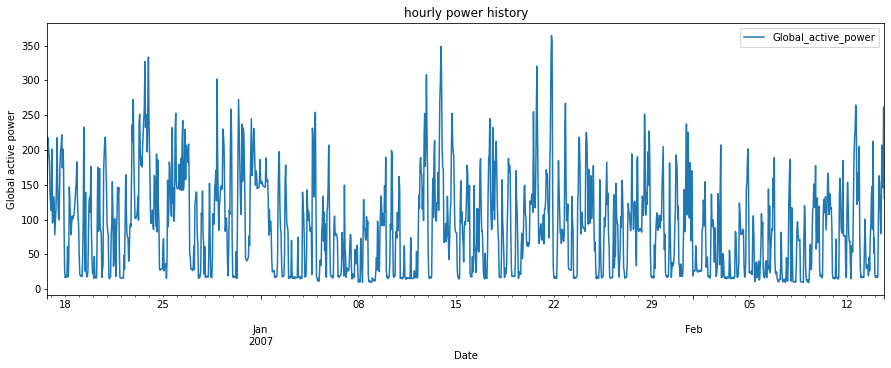

In [ ]:
fig = Hourly_1440.plot(x='Date_s',y='Global_active_power', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global active power')
fig.set(title='hourly power history')
plt.show(fig)

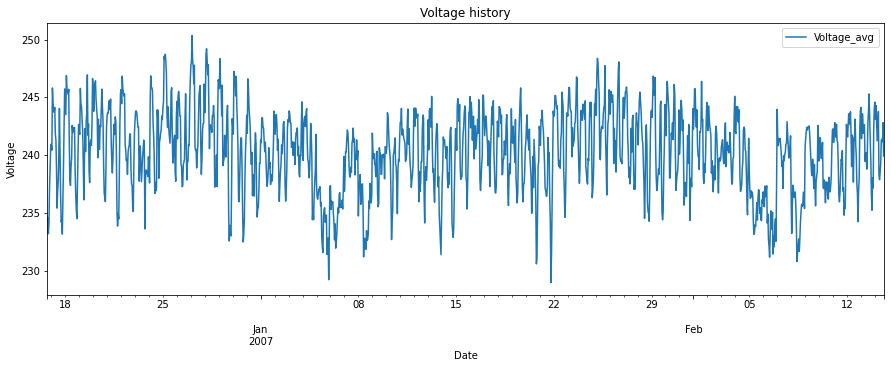

In [ ]:
fig = Hourly_1440.plot(x='Date_s',y='Voltage_avg', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Voltage')
fig.set(title='Voltage history')
plt.show(fig)

* *Daily pattern*

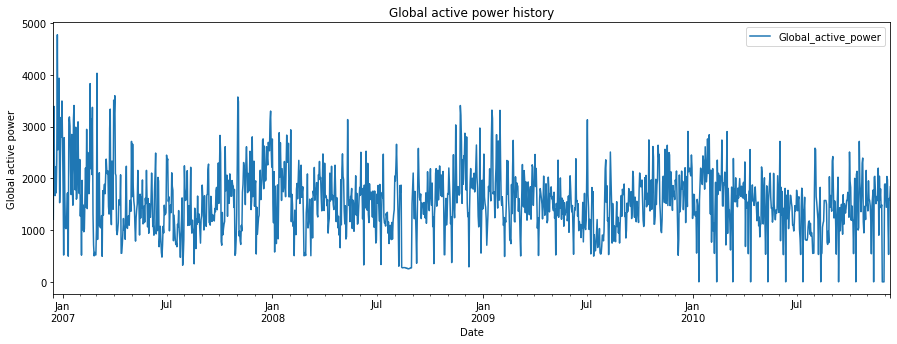

In [ ]:
fig = Daily_plt.plot(x='Date_s',y='Global_active_power', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global active power')
fig.set(title='Global active power history')
plt.show(fig)

* *Data resampled every 10 minutes*

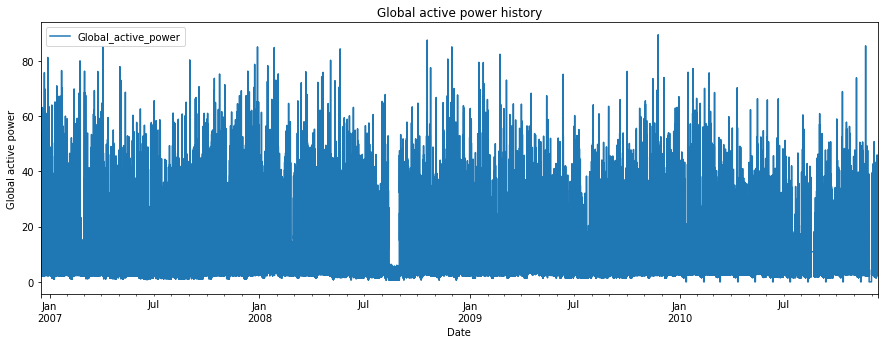

In [ ]:
fig = Min10_plt.plot(x='Date_s',y='Global_active_power', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global active power')
fig.set(title='Global active power history')
plt.show(fig)

* *plot raw data over a 24 hour period*

In [ ]:
minutely_24hr = hhpc_df.iloc[:1440,]

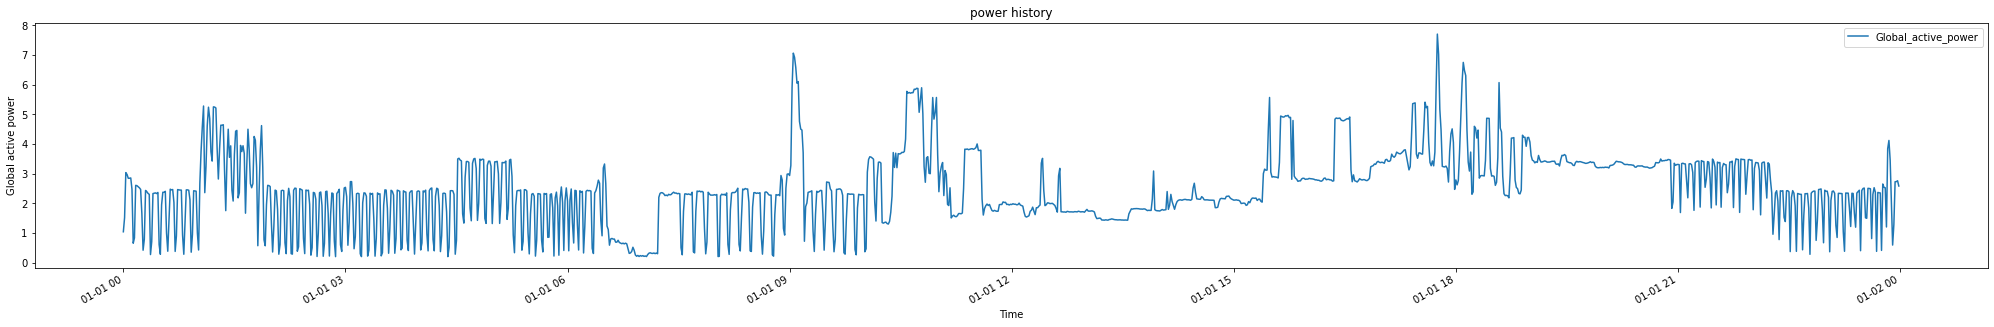

In [ ]:
fig = minutely_24hr.plot(x='Time',y='Global_active_power', kind='line', figsize=(35,5))
fig.set(xlabel='Time')
fig.set(ylabel='Global active power')
fig.set(title='power history')
plt.show(fig)

<a id='Aggregated_data_Trend'></a>
### 3.2. Aggregated data Trend

In [ ]:
hhpc_df_agg = hhpc_df.copy()

In [ ]:
hhpc_df_agg['day_of_week'] = hhpc_df['Date'].dt.weekday
hhpc_df_agg['hour_of_day'] = hhpc_df['Time'].dt.hour
hhpc_df_agg.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day_of_week,hour_of_day
0,2006-12-16,1900-01-01 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,5,17
1,2006-12-16,1900-01-01 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,5,17
2,2006-12-16,1900-01-01 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5,17
3,2006-12-16,1900-01-01 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,5,17
4,2006-12-16,1900-01-01 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,5,17


* *Variation over days of a week*

In [ ]:
df_gap = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Global_active_power':'mean'})

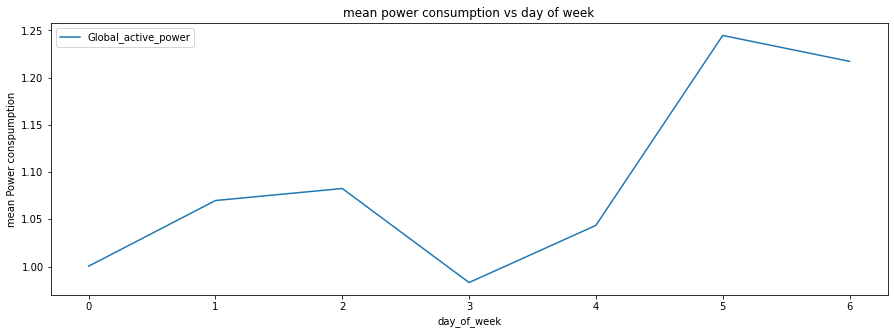

In [ ]:
fig = df_gap.plot(x='day_of_week',y='Global_active_power', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean Power conspumption')
fig.set(title='mean power consumption vs day of week')
plt.show(fig)

In [ ]:
df_rap = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Global_reactive_power':'mean'})

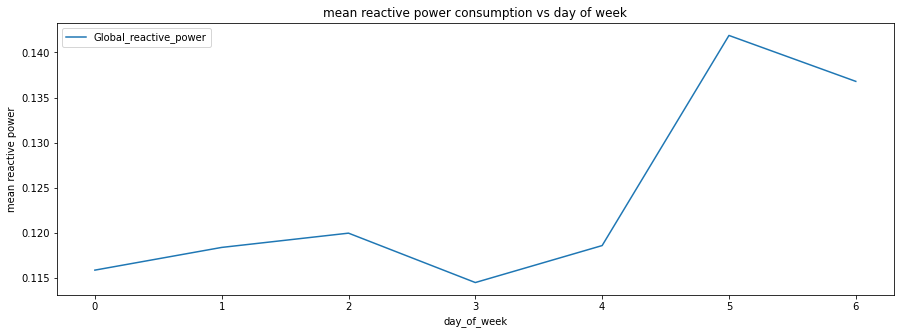

In [ ]:
fig = df_rap.plot(x='day_of_week',y='Global_reactive_power', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean reactive power')
fig.set(title='mean reactive power consumption vs day of week')
plt.show(fig)

In [ ]:
df_s1 = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Sub_metering_1':'mean'})

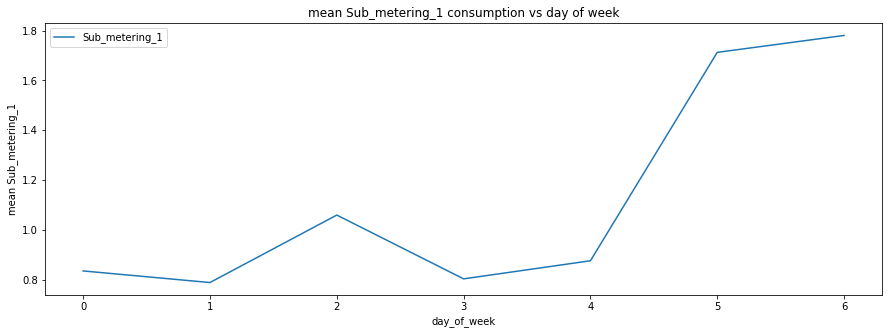

In [ ]:
fig = df_s1.plot(x='day_of_week',y='Sub_metering_1', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean Sub_metering_1')
fig.set(title='mean Sub_metering_1 consumption vs day of week')
plt.show(fig)

In [ ]:
df_s2 = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Sub_metering_2':'mean'})

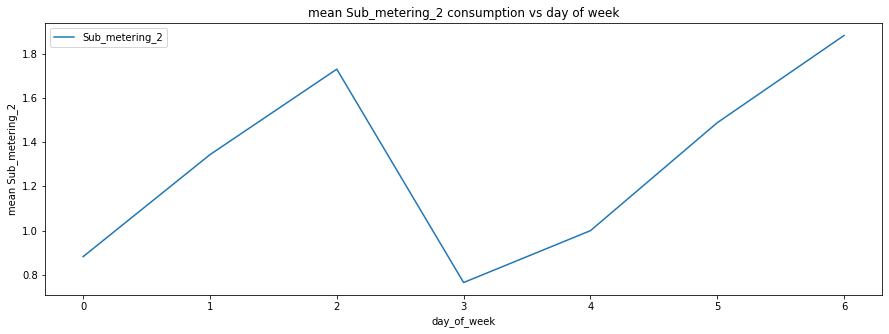

In [ ]:
fig = df_s2.plot(x='day_of_week',y='Sub_metering_2', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean Sub_metering_2')
fig.set(title='mean Sub_metering_2 consumption vs day of week')
plt.show(fig)

In [ ]:
df_s3 = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Sub_metering_3':'mean'})

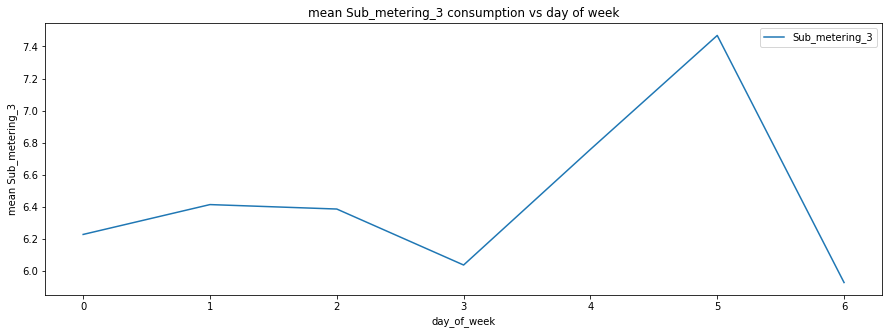

In [ ]:
fig = df_s3.plot(x='day_of_week',y='Sub_metering_3', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean Sub_metering_3')
fig.set(title='mean Sub_metering_3 consumption vs day of week')
plt.show(fig)

<a id='Feature_relationships'></a>
### 3.3. Feature relationships

* *Correlation between features*

In [ ]:
hhpc_corr = hhpc_df.corr()

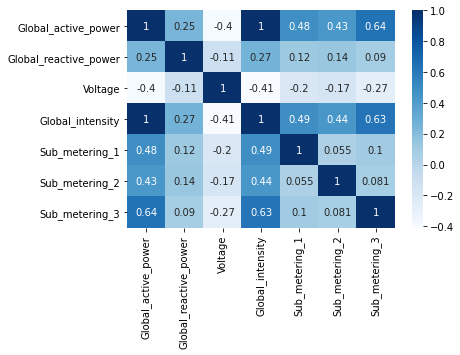

In [ ]:
fig = sns.heatmap(hhpc_corr, annot = True, cmap='Blues')
plt.show(fig)

* *Explore feature relationship via pair-plot*

In [ ]:
cols = hhpc_df.columns
cols

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [ ]:
col_vars = ['Global_active_power','Global_reactive_power','Voltage', 'Global_intensity','Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
hhpc_cols = hhpc_df[col_vars]

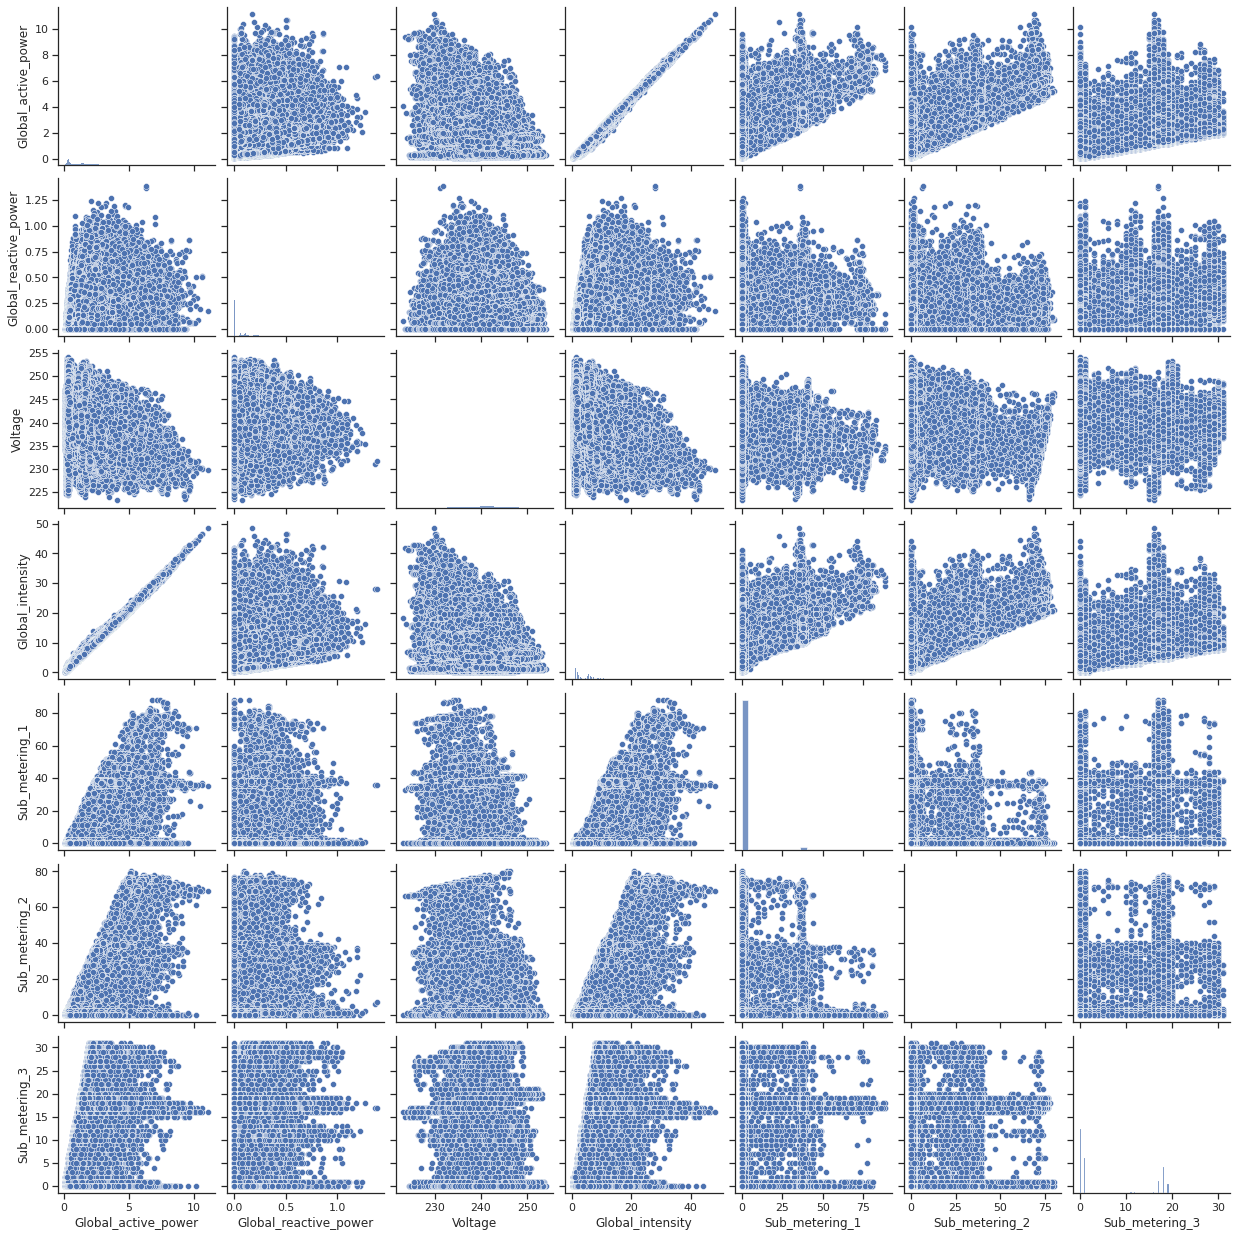

In [ ]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(hhpc_cols)
plt.show(fig)

* *Explore distribution of features*

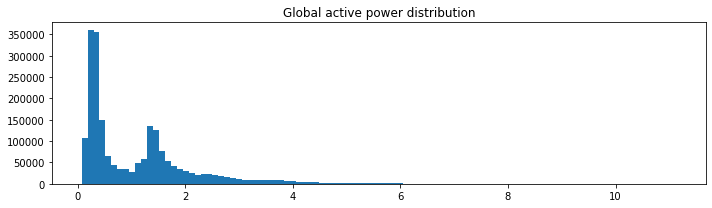

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Global_active_power'],bins=100)
plt.title('Global active power distribution')
plt.show(fig)

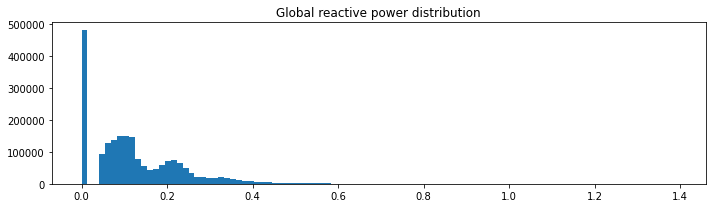

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Global_reactive_power'],bins=100)
plt.title('Global reactive power distribution')
plt.show(fig)

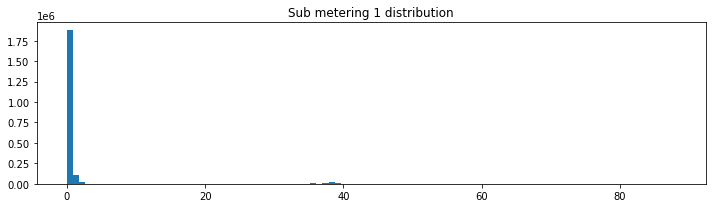

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Sub_metering_1'],bins=100)
plt.title('Sub metering 1 distribution')
plt.show(fig)

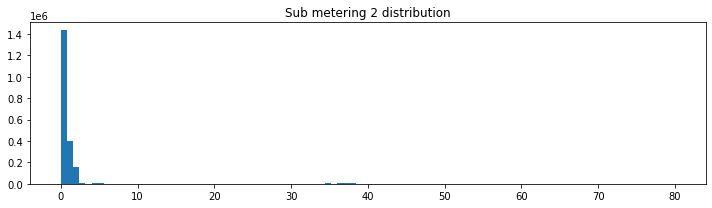

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Sub_metering_2'],bins=100)
plt.title('Sub metering 2 distribution')
plt.show(fig)

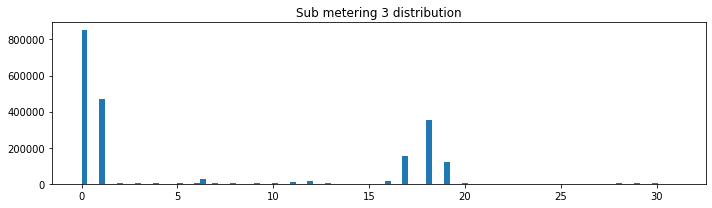

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Sub_metering_3'],bins=100)
plt.title('Sub metering 3 distribution')
plt.show(fig)

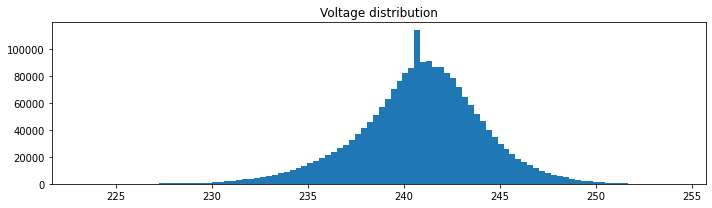

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Voltage'],bins=100)
plt.title('Voltage distribution')
plt.show(fig)

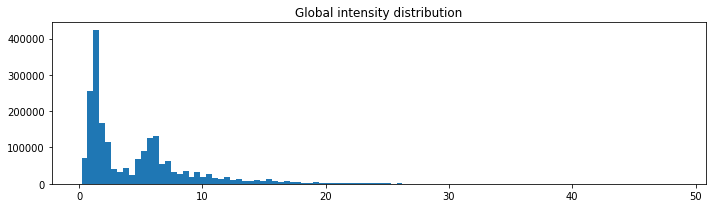

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Global_intensity'],bins=100)
plt.title('Global intensity distribution')
plt.show(fig)

<a id='EDA_Summary'></a>
### 3.4. EDA Summary

* *Power consumption is highest in Jan and lowest around August*
* *voltage stays nearly steady*
* *Power consumption increases during the weekends*
* *There is strong correlation between power consumption and intensity. Power is proportional to current*
* *Kitchen power consumption increases during weekend*
* *Laundry related power consumption peaks mid-week and over weekends*
* *Hot water and air-conditioning usage peaks over weekends*
 



<a id='TSA'></a>
## 4. Time Series Analysis
<a id='FND'></a>
### 4.1 Forecasting Global active power for the next day

<a id='DP_SR60_ND'></a>
### 4.1.1 Preparing data using sampling rate of 60 for next-day forecasting

* **Data timesteps and samples for next day prediction:**
* *Timesteps: 24 hours of data sampled once per hour = 24*
* *Taget: The Global active power on the 25th hour*
* *Samples: shifted by 1 minute since the entire dataset is used*

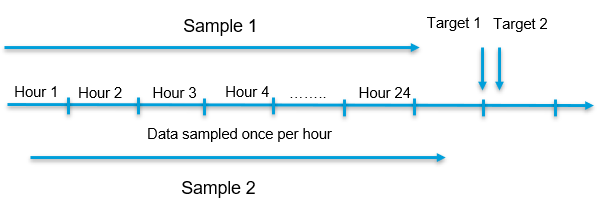

* *drop the date time columns*

In [ ]:
hhpc_7col = hhpc_df.drop(columns=['DateTime'])

* *Apply Standard scaling*

In [ ]:
scaler = StandardScaler()
hhpc_np = scaler.fit_transform(hhpc_7col)
hhpc_np.shape

(2075259, 7)

* *Split data*
* *training (50%)* 
* *validation(25%)* 
* *test datasets(25%)*

In [ ]:
num_train_samples = int(0.5 * len(hhpc_np))
num_val_samples = int(0.25 * len(hhpc_np))
num_test_samples = len(hhpc_np) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1037629
num_val_samples: 518814
num_test_samples: 518816


In [ ]:
Gap = hhpc_df['Global_active_power'].values

In [ ]:
sampling_rate = 60
sequence_length = 24
delay = sampling_rate * (sequence_length + 1 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_np[:-delay],
    targets=Gap[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_np[:-delay],
    targets=Gap[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_np[:-delay],
    targets=Gap[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

<a id='BN_SR60_ND'></a>
### 4.1.2 Baseline naive next-day forecasting using a sampling rate of 60

* *baseline Naive forecast:set the previous global active power value as the predicted value*

In [ ]:
hhpc_cmp = hhpc_np.copy()
mean = hhpc_cmp[:num_train_samples].mean(axis=0)
hhpc_cmp -= mean
std = hhpc_cmp[:num_train_samples].std(axis=0)
hhpc_cmp /= std

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 0] * std[0] + mean[0]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 1.25
Test MAE: 1.22


<a id='BM_SR60_ND'></a>
### 4.1.3 Building models using a sampling rate of 60 for next-day forecasting


In [ ]:
modelSR60 = Sequential()
modelSR60.add(LSTM(4))
modelSR60.add(Dropout(0.1))
modelSR60.add(Dense(2))
modelSR60.add(Dropout(0.1))
modelSR60.add(Dense(1))
modelSR60.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'Hourly_SR60_lstm_dropout_no_shuffle.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
historySR60 = modelSR60.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/20
4048/4048 [==============================] - 257s 62ms/step - loss: 1.5212 - mae: 0.8371 - val_loss: 0.7447 - val_mae: 0.6184
Epoch 2/20
4048/4048 [==============================] - 255s 63ms/step - loss: 1.0367 - mae: 0.7121 - val_loss: 0.7265 - val_mae: 0.6207
Epoch 3/20
4048/4048 [==============================] - 264s 65ms/step - loss: 1.0030 - mae: 0.6925 - val_loss: 0.7265 - val_mae: 0.6253
Epoch 4/20
4048/4048 [==============================] - 265s 65ms/step - loss: 0.9863 - mae: 0.6851 - val_loss: 0.7230 - val_mae: 0.6220
Epoch 5/20
4048/4048 [==============================] - 268s 66ms/step - loss: 0.9730 - mae: 0.6795 - val_loss: 0.7213 - val_mae: 0.6197
Epoch 6/20
4048/4048 [==============================] - 263s 65ms/step - loss: 0.9659 - mae: 0.6768 - val_loss: 0.7173 - val_mae: 0.6153
Epoch 7/20
4048/4048 [==============================] - 264s 65ms/step - loss: 0.9606 - mae: 0.6747 - val_loss: 0.7151 - val_mae: 0.6141
Epoch 8/20
4048/4048 [===================

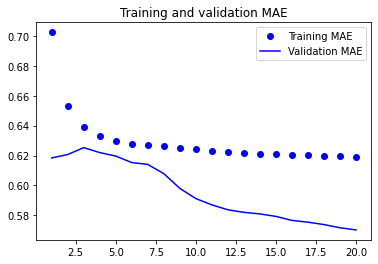

In [ ]:
loss = historySR60.history["mae"]
val_loss = historySR60.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
test_loss = modelSR60.evaluate(test_dataset)
test_predict = modelSR60.predict(test_dataset)

2016/2016 [==============================] - 79s 39ms/step - loss: 0.6115 - mae: 0.5498


In [ ]:
gap_test = Gap[num_train_samples + num_val_samples:]
gap_test_delay = gap_test[delay:]
predictions = test_predict.reshape(test_predict.size,)
d = {'test':gap_test_delay[0:len(predictions)],'pred':predictions}
df_plt = pd.DataFrame(d)

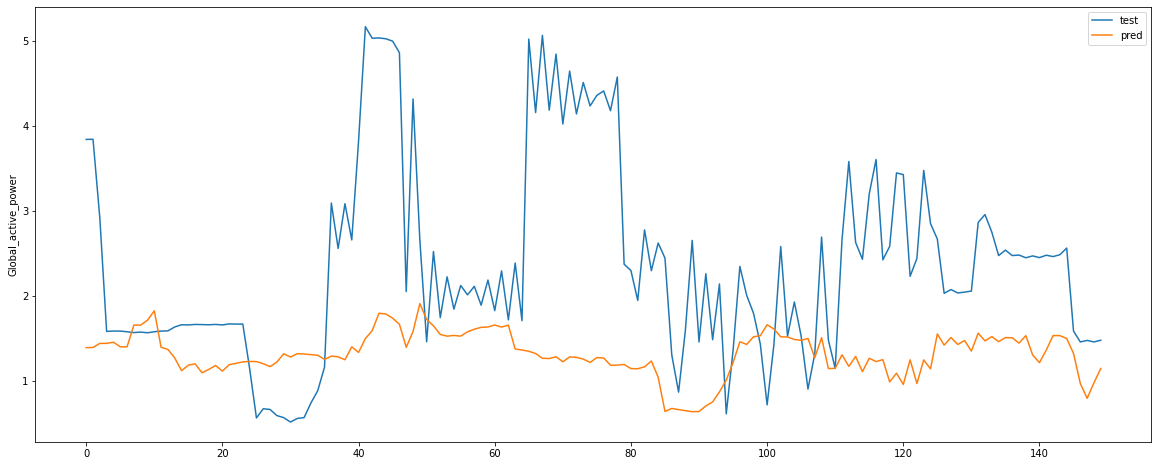

In [ ]:
fig = df_plt[0:150].plot(figsize=(20,8))
fig.set(ylabel='Global_active_power')
plt.show(fig)

<a id='BM_60SR_ND_obs'></a>
### 4.1.3a Observations on the model using a sampling rate of 60 for next-day forecast

* *Decreasing validation MAE suggests that the model seems to be converging.*
* *The MAE on the validation is lower compared to the training data because of the use of dropout which is used on the training but not on the validation set.*
* *The MAE on the test data set is comparable to the validation MAE.* 
* *The test MAE is better than the baseline naive case, i.e. LSTM outperforms the naive baseline case.*
* *The plot of test and predicted results indicate that the model lacks predictive capabity.*
* *The sample consists of every 60th datapoint.* 
* *A single datapoint fails to capture how the power usage varied over the 60 minutes period. This might explain why the model lacks predictivity.* 

<a id='DP_HR_ND'></a>
### 4.2.1 Data preparation using hourly resampled aggregate data for next-day forecast

* *Hourly resampled data captures the total power usage over the 60 minutes.* 
* *The global active power for every datapoint is used.*
* *Each timestep consists of 24 data points representing 24hours.*
* *The sample is shifted by 1 hour. In the previous case the shift was 1 minute.*

* **Prepare timesteps and samples for hourly resampled data**

In [ ]:
Hourly.isna().sum()
Hourly.fillna(Hourly.mean(),inplace=True)

In [ ]:
Hourly_7col = Hourly.drop(columns=['Voltage'])
Hourly_7col.head()

,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage_avg
DateTime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,651.6,0.0,19.0,607.0,234.643889
2006-12-16 18:00:00,217.932,4.802,936.0,0.0,403.0,1012.0,234.580167
2006-12-16 19:00:00,204.014,5.114,870.2,0.0,86.0,1001.0,233.232500
2006-12-16 20:00:00,196.114,4.506,835.0,0.0,0.0,1007.0,234.071500
2006-12-16 21:00:00,183.388,4.600,782.8,0.0,25.0,1033.0,237.158667


In [ ]:
scaler = StandardScaler()
Hourly_7col_np = scaler.fit_transform(Hourly_7col)
Hourly_7col_np.shape

(34951, 7)

In [ ]:
num_train_samples = int(0.5 * len(Hourly_7col_np))
num_val_samples = int(0.25 * len(Hourly_7col_np))
num_test_samples = len(Hourly_7col_np) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 17475
num_val_samples: 8737
num_test_samples: 8739


In [ ]:
Gap2 = Hourly_7col['Global_active_power'].values

In [ ]:
sampling_rate = 1
sequence_length = 24
delay = sampling_rate * (sequence_length + 1 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Hourly_7col_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Hourly_7col_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Hourly_7col_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

<a id='BM_HR_ND'></a>
### 4.2.2 Building model using hourly resampled aggregate data for next-day forecast

In [ ]:
modelH3 = Sequential()
modelH3.add(LSTM(5))
modelH3.add(Dropout(0.1))
modelH3.add(Dense(3))
modelH3.add(Dropout(0.1))
modelH3.add(Dense(1))
modelH3.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'Hourly_lstm_dropout_2_no_shuffle.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
historyH3 = modelH3.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/50
69/69 [==============================] - 35s 73ms/step - loss: 8939.4913 - mae: 71.3486 - val_loss: 6547.4165 - val_mae: 63.6162
Epoch 2/50
69/69 [==============================] - 4s 60ms/step - loss: 8825.0797 - mae: 70.5153 - val_loss: 6413.7686 - val_mae: 62.5815
Epoch 3/50
69/69 [==============================] - 4s 63ms/step - loss: 8646.6475 - mae: 69.2447 - val_loss: 6238.1274 - val_mae: 61.2539
Epoch 4/50
69/69 [==============================] - 4s 61ms/step - loss: 8434.4416 - mae: 67.8203 - val_loss: 6038.9907 - val_mae: 59.7308
Epoch 5/50
69/69 [==============================] - 4s 64ms/step - loss: 8193.3244 - mae: 66.1788 - val_loss: 5809.9727 - val_mae: 57.8392
Epoch 6/50
69/69 [==============================] - 5s 65ms/step - loss: 7931.0793 - mae: 64.2178 - val_loss: 5556.9326 - val_mae: 55.6074
Epoch 7/50
69/69 [==============================] - 4s 63ms/step - loss: 7660.3015 - mae: 62.0683 - val_loss: 5303.6187 - val_mae: 53.2675
Epoch 8/50
69/69 [========

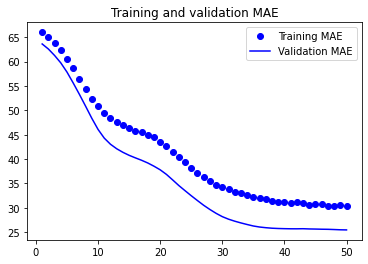

In [ ]:
loss = historyH3.history["mae"]
val_loss = historyH3.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
test_loss = modelH3.evaluate(test_dataset)
test_predict = modelH3.predict(test_dataset)

34/34 [==============================] - 1s 38ms/step - loss: 1129.7133 - mae: 24.2492


In [ ]:
gap_test = Gap2[num_train_samples + num_val_samples:]
gap_test_delay = gap_test[delay:]

In [ ]:
predictions = test_predict.reshape(test_predict.size,)
d = {'test':gap_test_delay[0:len(predictions)],'pred':predictions}
df_plt = pd.DataFrame(d)

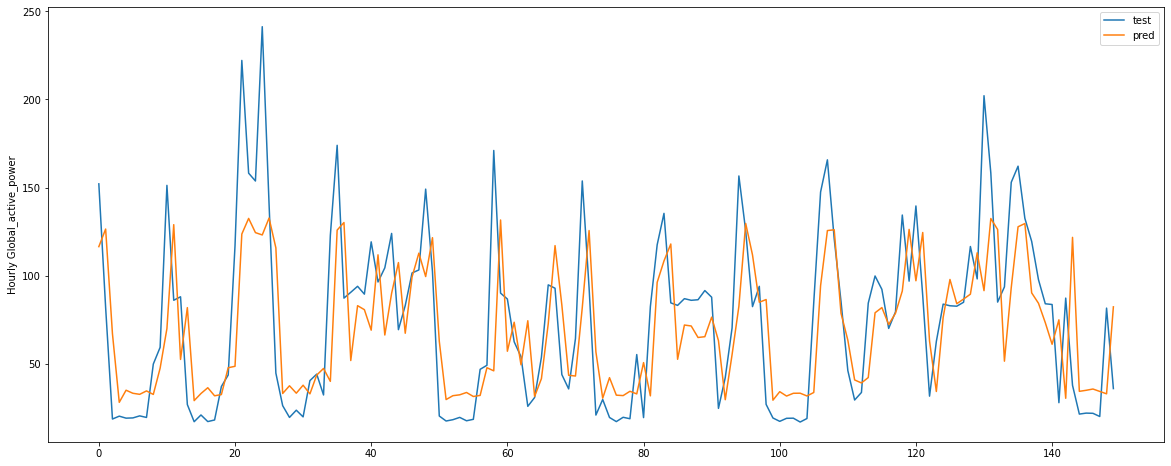

In [ ]:
fig = df_plt[0:150].plot(figsize=(20,8))
fig.set(ylabel='Hourly Global_active_power')
plt.show(fig)

<a id='BM_HR_ND_obs'></a>
### 4.2.2a Observations on modelusing hourly resampled aggreate data for next-day forecast

* *The plot of validation MAE indicates good convergence.*
* *Once again we observe that the validation MAE is lower compared to training MAE because of the dropouts in the model.*
* *The loss on the test data set indicates that the model has generalized well to unseen data.*
* *The comparison between the test and the predictions indicates that the model is able to pickup the trends in the data.*
* *We can see that hourly resampled data captures the power usage during the hour. This improves the LSTM model's predicitivity.*  
* *There are fewer samples in the dataset compared to previous case as can be seen from keras output. The runtime for the model is significantly less than the previous case.*
* *Further model tuning is required to improve model predictivity.*

<a id='Forecasting_for_NW'></a>
### 4.3 Forecasting Global active power for next-week

* *Here we attempt to extend the forecast horizon to next week instead of next day.*

<a id='DP_DR__NW'></a>
### 4.3.1 Data preparation using daily resampled aggregate data for next-week forecasting

* **Data timesteps and samples for next-week prediction:**
* *Timesteps: 7 days of data sampled once per day = 7*
* *Taget: The Global active power on the 8th day*
* *Samples: shifted by 1 day*
* *Daily resampled data is used*

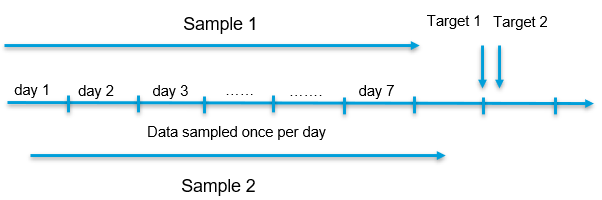

In [ ]:
Daily.shape

(1457, 8)

In [ ]:
Daily.isna().sum()
Daily.fillna(Daily.mean(),inplace=True)

In [ ]:
Daily_7col = Daily.drop(columns=['Voltage'])
Daily_7col.head()

,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage_avg
DateTime,,,,,,,
2006-12-16,1209.176,34.922,5180.8,0.0,546.0,4926.0,236.243763
2006-12-17,3390.460,226.006,14398.6,2033.0,4187.0,13341.0,240.087028
2006-12-18,2203.826,161.792,9247.2,1063.0,2621.0,14018.0,241.231694
2006-12-19,1666.194,150.942,7094.0,839.0,7602.0,6197.0,241.999313
2006-12-20,2225.748,160.998,9313.0,0.0,2648.0,14063.0,242.308063


In [ ]:
Gapd = Daily_7col['Global_active_power'].values

In [ ]:
scaler = StandardScaler()
Daily_7col_np = scaler.fit_transform(Daily_7col)
Daily_7col_np.shape

(1457, 7)

In [ ]:
num_train_samples = int(0.5 * len(Daily_7col_np))
num_val_samples = int(0.25 * len(Daily_7col_np))
num_test_samples = len(Daily_7col_np) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 728
num_val_samples: 364
num_test_samples: 365


In [ ]:
sampling_rate = 1
sequence_length = 7
delay = sampling_rate * (sequence_length + 1 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Daily_7col_np[:-delay],
    targets=Gapd[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Daily_7col_np[:-delay],
    targets=Gapd[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Daily_7col_np[:-delay],
    targets=Gapd[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

<a id='BN_DR_NW'></a>
### 4.3.2 Baseline naive next-week forecasting with daily resampled aggregate data

* *baseline Naive forecast:set the previous global active power value as the predicted value*

In [ ]:
Daily_7col_cmp = Daily_7col_np.copy()
mean = Daily_7col_cmp[:num_train_samples].mean(axis=0)
Daily_7col_cmp -= mean
std = Daily_7col_cmp[:num_train_samples].std(axis=0)
Daily_7col_cmp /= std

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 0] * std[0] + mean[0]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 1535.80
Test MAE: 1485.44


<a id='BM_DR_NW'></a>
### 4.3.3 Building models using daily resampled aggregate data for next week forecasting

In [ ]:
modelD = Sequential()
modelD.add(LSTM(4))
modelD.add(Dense(1))
modelD.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'Daily_lstm_no_shuffle.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
historyD = modelD.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/50
3/3 [==============================] - 5s 457ms/step - loss: 3054668.8750 - mae: 1601.3058 - val_loss: 2625496.7500 - val_mae: 1535.7661
Epoch 2/50
3/3 [==============================] - 0s 106ms/step - loss: 3054575.9375 - mae: 1601.2782 - val_loss: 2625467.2500 - val_mae: 1535.7570
Epoch 3/50
3/3 [==============================] - 0s 113ms/step - loss: 3054512.0000 - mae: 1601.2591 - val_loss: 2625442.7500 - val_mae: 1535.7495
Epoch 4/50
3/3 [==============================] - 0s 106ms/step - loss: 3054457.4375 - mae: 1601.2426 - val_loss: 2625419.7500 - val_mae: 1535.7427
Epoch 5/50
3/3 [==============================] - 0s 107ms/step - loss: 3054407.5000 - mae: 1601.2276 - val_loss: 2625398.7500 - val_mae: 1535.7362
Epoch 6/50
3/3 [==============================] - 0s 129ms/step - loss: 3054360.4375 - mae: 1601.2136 - val_loss: 2625378.2500 - val_mae: 1535.7297
Epoch 7/50
3/3 [==============================] - 0s 114ms/step - loss: 3054315.3125 - mae: 1601.2000 - val_loss

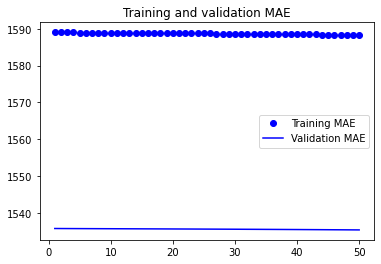

In [ ]:
loss = historyD.history["mae"]
val_loss = historyD.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

<a id='BM_DR_NW_obs'></a>
### 4.3.3a Observations on models using daily resampled aggregate data for next-week forecasting 

* *Both Train and test MAE fail to converge.*
* *There are too few sample for the model to learn from: only 728 samples in the training set.*

<a id='DP_HR_NW'></a>
### 4.4.1 Data preparation for next-week forecasting using hourly resampled aggregate data

In [ ]:
sampling_rate = 1
sequence_length = 168
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Hourly_7col_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Hourly_7col_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Hourly_7col_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

<a id='BN_HR_NW'></a>
### 4.4.2 Baseline naive next-week forecasting with hourly resampled aggreate data

In [ ]:
Hourly_7col_cmp = Hourly_7col_np.copy()
mean = Hourly_7col_cmp[:num_train_samples].mean(axis=0)
Hourly_7col_cmp -= mean
std = Hourly_7col_cmp[:num_train_samples].std(axis=0)
Hourly_7col_cmp /= std

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 0] * std[0] + mean[0]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 63.86
Test MAE: 61.83


<a id='BM_HR_NW'></a>
### 4.4.3 Building models using hourly resampled aggreate data for next-week forecasting

In [ ]:
modelH = Sequential()
modelH.add(LSTM(5))
modelH.add(Dropout(0.2))
modelH.add(Dense(3))
modelH.add(Dropout(0.2))
modelH.add(Dense(1))
modelH.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'Hourly_lstm_Reg_dropout_2.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
historyH = modelH.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/50
68/68 [==============================] - 15s 153ms/step - loss: 8629.1496 - mae: 69.9408 - val_loss: 6479.7930 - val_mae: 63.1416
Epoch 2/50
68/68 [==============================] - 10s 144ms/step - loss: 8513.5447 - mae: 69.0478 - val_loss: 6324.9902 - val_mae: 61.8953
Epoch 3/50
68/68 [==============================] - 10s 154ms/step - loss: 8328.7803 - mae: 67.6649 - val_loss: 6131.2632 - val_mae: 60.3528
Epoch 4/50
68/68 [==============================] - 11s 156ms/step - loss: 8116.8438 - mae: 66.1082 - val_loss: 5930.9922 - val_mae: 58.7365
Epoch 5/50
68/68 [==============================] - 10s 143ms/step - loss: 7892.0353 - mae: 64.4600 - val_loss: 5720.5625 - val_mae: 56.9858
Epoch 6/50
68/68 [==============================] - 10s 144ms/step - loss: 7656.9403 - mae: 62.6105 - val_loss: 5496.4004 - val_mae: 55.0268
Epoch 7/50
68/68 [==============================] - 10s 143ms/step - loss: 7395.5399 - mae: 60.6718 - val_loss: 5262.8740 - val_mae: 52.8714
Epoch 8/50
68

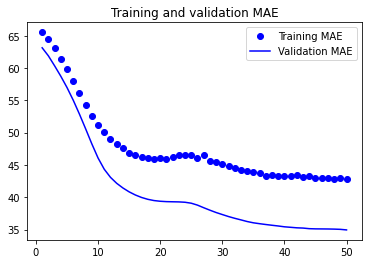

In [ ]:
loss = historyH.history["mae"]
val_loss = historyH.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
test_loss = modelH.evaluate(test_dataset)
test_predict = modelH.predict(test_dataset)

33/33 [==============================] - 2s 66ms/step - loss: 2112.6189 - mae: 35.0660


In [ ]:
gap_test = Gap2[num_train_samples + num_val_samples:]
gap_test_delay = gap_test[delay:]

In [ ]:
predictions = test_predict.reshape(test_predict.size,)
d = {'test':gap_test_delay[0:len(predictions)],'pred':predictions}
df_plt = pd.DataFrame(d)

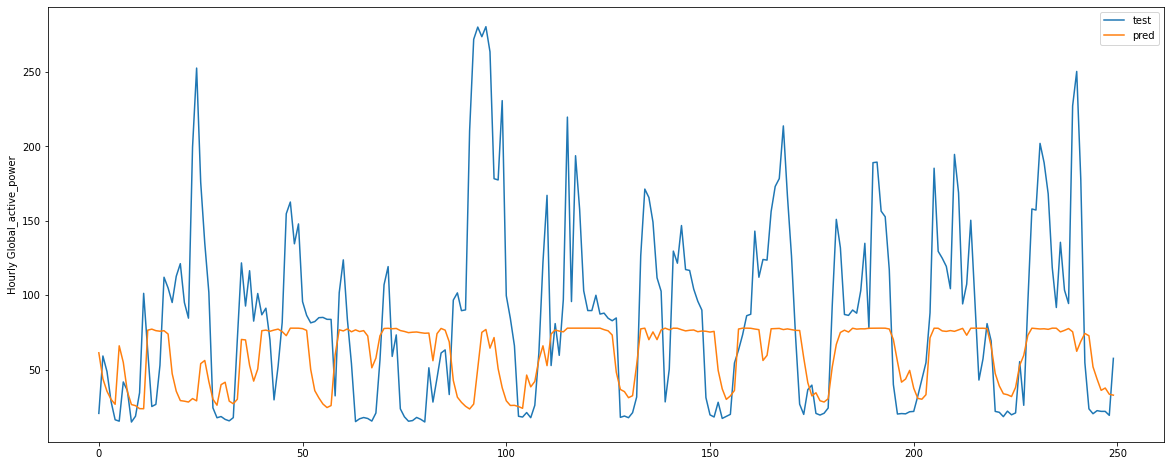

In [ ]:
fig = df_plt[0:250].plot(figsize=(20,8))
fig.set(ylabel='Hourly Global_active_power')
plt.show(fig)

<a id='BM_HR_NW_obs'></a>
### 4.4.3a Observations on the model using hourly resample aggregate data for next-week forecasting

* *The MAE for training and validation shows improved convergence*
* *The MAE for testdata is comparable to validation data suggesting the model has not overfit.*
* *The comparison of test and predicted results show that the model lacks predictivity.*

<a id='Forecasting_for_NH'></a>
### 4.5 Forecasting Global active power for the next-hour

* *Here we attempt to forecast Global active power for the next hour using the 10min aggregated data.*
** *
* **Data timesteps and samples for next-hour prediction:**
* *Timesteps: 6 data sampled 10mins per hour = 6*
* *Taget: The Global active power at the next hour*
* *Samples: shifted by 10min*
* *Daily resampled data is used*

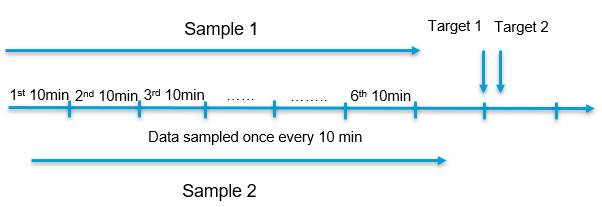

<a id='DP_10R__NH'></a>
### 4.5.1 Data preparation using 10min resampled aggregate data for next-hour forecasting

In [ ]:
Min10.fillna(Min10.mean(),inplace=True)
Min10.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Voltage_avg              0
dtype: int64

In [ ]:
Min10_7col = Min10.drop(columns=['Voltage'])
Min10_7col.head()

,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage_avg
DateTime,,,,,,,
2006-12-16 17:20:00,27.524,2.904,118.2,0.0,8.0,101.0,234.366667
2006-12-16 17:30:00,42.522,4.608,182.8,0.0,11.0,168.0,234.208000
2006-12-16 17:40:00,47.216,0.308,202.6,0.0,0.0,169.0,234.845000
2006-12-16 17:50:00,34.762,0.424,148.0,0.0,0.0,169.0,235.045000
2006-12-16 18:00:00,46.904,1.526,200.8,0.0,236.0,169.0,234.975000


In [ ]:
Gap10 = Min10_7col['Global_active_power'].values

In [ ]:
scaler = StandardScaler()
Min10_7col_np = scaler.fit_transform(Min10_7col)
Min10_7col_np.shape

(209704, 7)

In [ ]:
num_train_samples = int(0.5 * len(Min10_7col_np))
num_val_samples = int(0.25 * len(Min10_7col_np))
num_test_samples = len(Min10_7col_np) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 104852
num_val_samples: 52426
num_test_samples: 52426


In [ ]:
sampling_rate = 1
sequence_length = 6
delay = sampling_rate * (sequence_length + 1 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Min10_7col_np[:-delay],
    targets=Gap10[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Min10_7col_np[:-delay],
    targets=Gap10[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    Min10_7col_np[:-delay],
    targets=Gap10[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

<a id='BN_10R_NH'></a>
### 4.5.2 Baseline naive next-hour forecasting with 10min resampled aggregate data

In [ ]:
Min10_7col_cmp = Min10_7col_np.copy()
mean = Min10_7col_cmp[:num_train_samples].mean(axis=0)
Min10_7col_cmp -= mean
std = Min10_7col_cmp[:num_train_samples].std(axis=0)
Min10_7col_cmp /= std

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 0] * std[0] + mean[0]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 10.69
Test MAE: 10.37


<a id='BM_10R_NH'></a>
### 4.5.3 Building models using 10min resampled aggregate data for next hour forecasting

In [ ]:
modelM10 = Sequential()
modelM10.add(LSTM(5))
modelM10.add(Dropout(0.2))
modelM10.add(Dense(3))
modelM10.add(Dropout(0.2))
modelM10.add(Dense(1))
modelM10.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'Min10_lstm_dropout_2.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
historyM10 = modelM10.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/50
410/410 [==============================] - 52s 55ms/step - loss: 244.0632 - mae: 10.9792 - val_loss: 86.7661 - val_mae: 5.7518
Epoch 2/50
410/410 [==============================] - 22s 55ms/step - loss: 122.0985 - mae: 6.8751 - val_loss: 41.0079 - val_mae: 3.5806
Epoch 3/50
410/410 [==============================] - 22s 54ms/step - loss: 77.6529 - mae: 5.3745 - val_loss: 30.5187 - val_mae: 3.1543
Epoch 4/50
410/410 [==============================] - 22s 54ms/step - loss: 62.4214 - mae: 4.7690 - val_loss: 27.2489 - val_mae: 2.9897
Epoch 5/50
410/410 [==============================] - 22s 55ms/step - loss: 55.7634 - mae: 4.5150 - val_loss: 25.6881 - val_mae: 2.9024
Epoch 6/50
410/410 [==============================] - 22s 54ms/step - loss: 52.7011 - mae: 4.3779 - val_loss: 24.8337 - val_mae: 2.8770
Epoch 7/50
410/410 [==============================] - 22s 54ms/step - loss: 50.2846 - mae: 4.2953 - val_loss: 24.4575 - val_mae: 2.8468
Epoch 8/50
410/410 [=========================

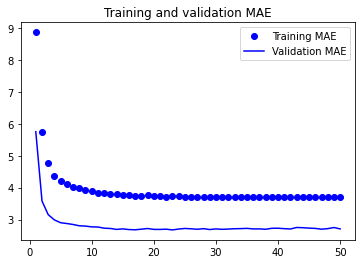

In [ ]:
loss = historyM10.history["mae"]
val_loss = historyM10.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
test_loss = modelM10.evaluate(test_dataset)
test_predict = modelM10.predict(test_dataset)

205/205 [==============================] - 8s 37ms/step - loss: 16.5860 - mae: 2.5511


In [ ]:
gap_test = Gap10[num_train_samples + num_val_samples:]
gap_test_delay = gap_test[delay:]

In [ ]:
predictions = test_predict.reshape(test_predict.size,)
d = {'test':gap_test_delay[0:len(predictions)],'pred':predictions}
df_plt = pd.DataFrame(d)

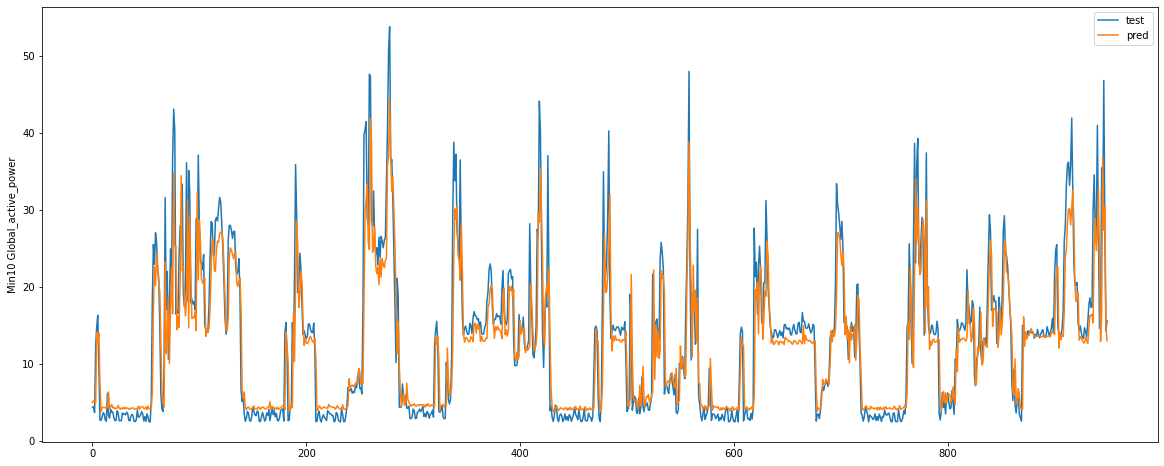

In [ ]:
fig = df_plt[0:950].plot(figsize=(20,8))
fig.set(ylabel='Min10 Global_active_power')
plt.show(fig)

<a id='BM_10R_NH_obs'></a>
### 4.5.3a Observations on the model using 10min resample aggregate data for next-hour forecasting

* *The train and validation MAE plot shows rapid convergence within 10 epochs. After that the convergence stays flat. The model learns rapidly from the data.*
* *The test MAE is lower than the baseline naive forecast and the validation MAE indicating that the model has generalized well.*
* *Comparison of the predicted to test Global active power shows that the model is picking up the trends very well.*

<a id='Conclusion'></a>
## 5. Conclusions

* **Next-day forecast:**
* *Sampling data once every 60 minutes lacks the information the model needs to learn because it doesn't contain the information of power usage during that duration.*
* *Using hourly resampled data worked well for the next-day forecast.*
* **Next-week forecast:**
* *Using daily sampled data didn't work well because there are too few samples to learn from.*
* *Using hourly resampled data lacks the predicitivity for next-week forecast.*
* **Next-hour forecast:**
* *Using 10min sampled data works well for the next hour forecast.*
* **General:**
* *More tuning will improve the model predictivity.*
* *For the given data LSTM performs well for next-hour and next day forecast. The preformance for the next week forecast is poor.*
* *More feautures is likely to improve model predictivity. Adding more submetering features, including household size, use of power backup systems, generators and alternative sources of energy like solar panels are few examples.*  

<a id='Appendix'></a>
## 6. Appendix

<a id='XGBoost'></a>
## 6.1 XGBoost

* *Try a regression problem. We are not predicting ahead in time. So this is not a direct comparison with LSTM.*

In [ ]:
hhpc_ftr_only = hhpc_sm_cmb.drop(columns=['Global_active_power'])

In [ ]:
X = hhpc_ftr_only.to_numpy()
size = int(len(X)*0.7)

* *Apply Standard scaling*

In [ ]:
scaler = StandardScaler()
X_scl = scaler.fit_transform(hhpc_ftr_only)
size = int(len(X_scl)*0.7)

* *split train (70%) test (30%)*

In [ ]:
X_train, X_test = X_scl[0:size,:], X_scl[size:len(X)]
y_train, y_test = Gap2[0:size], Gap2[size:len(X)]

In [ ]:
modelGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
modelGB.fit(X_train,y_train)

[19:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

* *evalute model on the test data*

In [ ]:
y_pred = modelGB.predict(X_test)
mean_absolute_error(y_test,y_pred)

0.3040536780978424

In [ ]:
r2 = r2_score(y_test,y_pred)
print(r2)

0.7868271841764412


* *XGBoost seems to preform resonably well for the regression problem*

<a id='ARIMA'></a>
## 6.2 ARIMA

In [ ]:
pip install "statsmodels==0.11.1"

     |████████████████████████████████| 8.7 MB 3.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [ ]:
hhpc_df1 = pd.read_table("household_power_consumption.txt",sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
cols_keep = ['Date','Time','Global_active_power']
gap_df = hhpc_df1[cols_keep]
gap_df['DateTime'] = pd.to_datetime(gap_df['Date']+' '+gap_df['Time'])
gap_df.drop(columns=['Date','Time'],inplace=True)
gap_df.index = gap_df.DateTime
gap_df.drop(columns=['DateTime'],inplace=True)
gap_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Global_active_power
DateTime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [ ]:
gap_df['Global_active_power']=pd.to_numeric(gap_df['Global_active_power'],errors='coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
gap_df['Global_active_power']=pd.to_numeric(gap_df['Global_active_power'],errors='coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
gap_df.fillna(gap_df.mean(),inplace=True)
gap_df.isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Global_active_power    0
dtype: int64

In [ ]:
gap_df_shift = gap_df - gap_df.shift()

In [ ]:
gap_df_shift.head(3)

,Global_active_power
DateTime,
2006-12-16 17:24:00,NaN
2006-12-16 17:25:00,1.144
2006-12-16 17:26:00,0.014


In [ ]:
plot_acf(gap_df_shift,lags=10)

In [ ]:
roll_mean = gap_df.rolling(window=1440).mean()
roll_std = gap_df.rolling(window=1440).std()

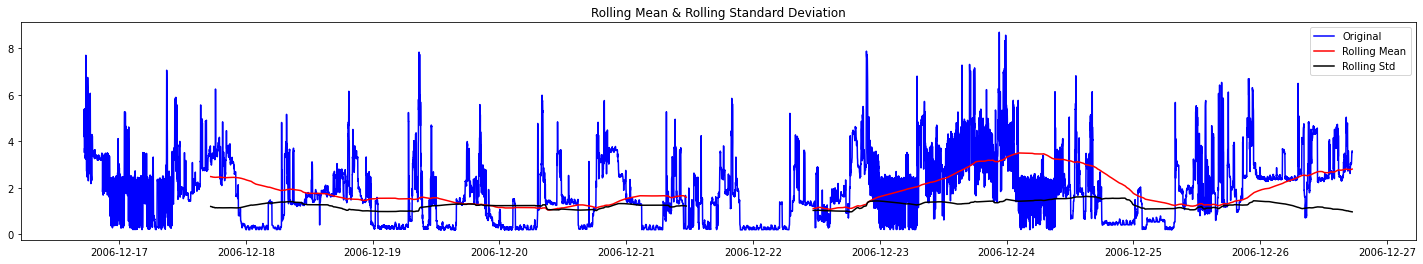

In [ ]:
plt.figure(figsize=(25,4))
plt.plot(gap_df[0:14400], color = 'blue', label = 'Original')
plt.plot(roll_mean[0:14400], color = 'red', label = 'Rolling Mean')
plt.plot(roll_std[0:14400], color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:
result = adfuller(gap_df['Global_active_power'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
model = ARIMA(gap_df, order=(1,1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

In [ ]:
model_fit = model.fit()

In [ ]:
gap_df['forecast'] = model_fit.predict()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


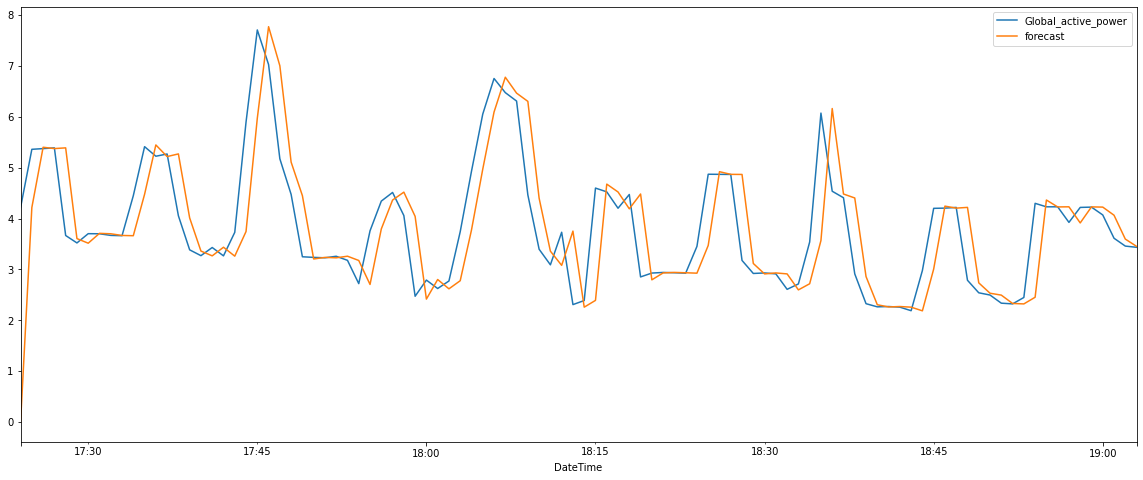

In [ ]:
gap_df[['Global_active_power','forecast']][0:100].plot(figsize=(20,8))